# Project Airbnb in Rio  - Prediction Model for Property Hosting/Renting Price 

### Project Context

Airbnb is a company that anyone that has a room or a property of any kind can offer their place to be rented similarly as hotels would. 

You, as a host, create your profile and the ad for your place, describing its characteristics as complete as possible, aiming to make your venue more attractive. Through your description that travelers and others choose the place that fits the best for them.

Airbnb allows customization in several different ways in the host listing, since minimum number of nights, price, number of rooms, even cancelation rules, extra fee for extra guests, landlord identity verification requirement, etc.

### Objective

    1 - For the landlord: Build a price prediction model that allows the ordinary person who has a property to know how much they should be the daily rate of their place;

    2 - For the renter: For a given property that he/she is looking for, help him/her understand whether that property has a attractive price or not.

### Available material

The database were obtained from the website Kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

    1 - The database are the prices of properties obtained and their respective characteristics in each month;
    2 - The prices are in reais (R$, brazilian currency)
    3 - The databases go from april 2018 to may 2020, with the exception of june 2018 that does not have any data 

### Initial Expectations

    1 - Seasonality should be an important factor, since months like december usually tend to be more expensive in turistic cities like Rio de Janeiro;
    2 - The property location should make a big difference in price. Characteristics like security or tourist attractions can be completely different from one neighborhood to another;  
    3 - Amenities can have a significant impact in price, since Rio de Janeiro has many old buildings.

### Importing Libraries and the Database

In [1]:
import pandas as pd
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from datetime import datetime


In [2]:
path_database = pathlib.Path('dataset')
db = pd.DataFrame() #First creater a empty dataframe

month_dict = {'jan': 1,'fev': 2,'mar': 3,
              'abr': 4,'mai': 5,'jun': 6,
              'jul': 7,'ago': 8,'set': 9,
              'out': 10,'nov': 11,'dez': 12,} # Dictionary to convert the month initials into intenger

for file in path_database.iterdir(): # Look in the database directory for each file

    file_data = pd.read_csv(file) # Read the respective month file
    file_data['month'] = month_dict[file.name[:3]] # Adding the Month Column
    file_data['year'] = int(file.name[-8:-4]) # Adding the Year Column
    db = pd.concat([db,file_data]) #Here, we add all the information in each .csv file in the dataframe with the aditional columns

C:\Users\ranon\AppData\Local\Temp\ipykernel_15212\1647751047.py:11: DtypeWarning: Columns (62,87) have mixed types. Specify dtype option on import or set low_memory=False.
  file_data = pd.read_csv(file) # Read the respective month file
C:\Users\ranon\AppData\Local\Temp\ipykernel_15212\1647751047.py:11: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  file_data = pd.read_csv(file) # Read the respective month file
C:\Users\ranon\AppData\Local\Temp\ipykernel_15212\1647751047.py:11: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  file_data = pd.read_csv(file) # Read the respective month file
C:\Users\ranon\AppData\Local\Temp\ipykernel_15212\1647751047.py:11: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  file_data = pd.read_csv(file) # Read the respective month file
C:\Users\ranon\AppData\Local\Temp\ipykernel_15212

### Consolidating the Database

First, we analyze every column to eliminate the ones that are not compatible to what we are looking for in order to make the database cleaner and faster. To do that, we created a .csv file with the first 1000 rows of the database. Examples of what were removed from our analyses:

    1 - 'id', 'listing_url', 'scrape_id', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_acceptance_rate','host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host verification', 'host_has_profile_pic', 'host_identity_verified', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped', 'first_review', 'last_review', 'requires_license', 'license', 'jurisdiction_names', 'require_guest_profile_picture', 'require_guest_phone_verification', 'calculated_host_listings_count', 'reviews_per_month','minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm','number_of_reviews_ltm','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms'  doesn't have any relevant information;
    2 - 'last_scraped' have the same information of date that we already added to the database (month, year);
    3 - 'name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', are columns with text written by the owner. This model does not have any kind of word analysis.
    4 - 'experience_offered' have only 'none' values;
    5 - 'host_listings_count' and 'host_total_listings_count' are basically the same column (only 460 values are different). 'host_total_listing_count' was chosen to be removed from the database;
    6 - 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact' are all metrics for location. The 'latitude' and 'longitude' are enough for our study;   
    7 - 'square_feet' have too many empty values and had to be removed;
    8 - Only daily price is under analyzes, so 'weekly_price' and 'monthly_price' can be removed;

That means that only 34 out of the 108 columns have relevant data. The code in the cell below was used to further analyse a few columns mentioned in this topic. 

In [3]:
number_empty  = db[['experiences_offered']].value_counts()
number_equals = (db['host_listings_count'] == db['host_total_listings_count']).value_counts()
number_nulls  = db['square_feet'].isnull().sum()

print("Number of empty rows in the column 'experiences_offered': \n{}".format(number_empty))
print("\nNumber of equal rows when comparing the columns 'host_listings_count' and 'host_total_listings_count': \n{}".format(number_equals))
print("\nNumber of nulls in the column 'square_feet': \n{}".format(number_nulls))


Number of empty rows in the column 'experiences_offered': 
experiences_offered
none                   902210
Name: count, dtype: int64

Number of equal rows when comparing the columns 'host_listings_count' and 'host_total_listings_count': 
True     901750
False       460
Name: count, dtype: int64

Number of nulls in the column 'square_feet': 
888162


Now that we have the columns with values that matter to this study, we filter the database.

In [4]:
relevant_columns = ['host_response_time','host_response_rate','host_is_superhost',
                    'host_listings_count','latitude','longitude','property_type',
                    'room_type','accommodates','bathrooms','bedrooms','beds','bed_type',
                    'amenities','price','security_deposit','cleaning_fee','guests_included',
                    'extra_people','minimum_nights','maximum_nights','number_of_reviews',
                    'review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
                    'review_scores_checkin','review_scores_communication',
                    'review_scores_location','review_scores_value','instant_bookable',
                    'is_business_travel_ready','cancellation_policy','month','year']

db = db.loc[:,relevant_columns]

display(db)

host_response_time host_response_rate host_is_superhost  \
0                     NaN                NaN                 f   
1          within an hour               100%                 t   
2          within an hour               100%                 f   
3          within an hour               100%                 f   
4          within an hour               100%                 t   
...                   ...                ...               ...   
34324      within an hour                93%                 f   
34325                 NaN                NaN                 f   
34326  within a few hours                74%                 f   
34327                 NaN                NaN                 f   
34328  a few days or more                38%                 f   

       host_listings_count   latitude  longitude property_type  \
0                      1.0 -22.946854 -43.182737     Apartment   
1                      2.0 -22.965919 -43.178962   Condominium   
2                      1.0 -22.985698 -43.201935     Apartment   
3                      3.0 -22.977117 -43.190454     Apartment   
4                      1.0 -22.983024 -43.214270     Apartment   
...                    ...        ...        ...           ...   
34324                  0.0 -23.003180 -43.342840     Apartment   
34325                  0.0 -22.966640 -43.393450     Apartment   
34326                 32.0 -22.962080 -43.175520     Apartment   
34327                  0.0 -23.003400 -43.341820     Apartment   
34328                  5.0 -23.010560 -43.363350     Apartment   

             room_type  accommodates  bathrooms  ...  \
0      Entire home/apt             4        1.0  ...   
1      Entire home/apt             5        1.0  ...   
2      Entire home/apt             2        1.0  ...   
3      Entire home/apt             3        1.0  ...   
4      Entire home/apt             3        1.0  ...   
...                ...           ...        ...  ...   
34324  Entire home/apt             4        1.0  ...   
34325  Entire home/apt             4        2.0  ...   
34326  Entire home/apt             5        1.0  ...   
34327  Entire home/apt             4        1.0  ...   
34328     Private room             2        0.0  ...   

       review_scores_cleanliness  review_scores_checkin  \
0                            9.0                    9.0   
1                            9.0                   10.0   
2                           10.0                   10.0   
3                           10.0                   10.0   
4                           10.0                   10.0   
...                          ...                    ...   
34324                        NaN                    NaN   
34325                        NaN                    NaN   
34326                        NaN                    NaN   
34327                        NaN                    NaN   
34328                        NaN                    NaN   

      review_scores_communication review_scores_location review_scores_value  \
0                             9.0                    9.0                 9.0   
1                            10.0                    9.0                 9.0   
2                            10.0                   10.0                 9.0   
3                            10.0                   10.0                 9.0   
4                            10.0                   10.0                 9.0   
...                           ...                    ...                 ...   
34324                         NaN                    NaN                 NaN   
34325                         NaN                    NaN                 NaN   
34326                         NaN                    NaN                 NaN   
34327                         NaN                    NaN                 NaN   
34328                         NaN                    NaN                 NaN   

      instant_bookable is_business_travel_ready          cancellation_policy  

### Treating Missing Values

When we start to look for empty values in the columns, we can see that the columns 'host_response_time', 'host_response_rate', 'security_deposit', 'cleaning_fee', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location' and 'review_scores_value' have too many of those, more than 310000 (about 33% of the columns values). We choose to remove all of them, since some of them probably are not truly relevant to the price. The  others, if adapted in any way, might accidentaly bias the model.

The code below were used to find these columns and remove them. After that, we have 23 columns.

In [5]:
print(db.isnull().sum())

host_response_time             401843
host_response_rate             401846
host_is_superhost                 460
host_listings_count               460
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                        1724
bedrooms                          850
beds                             2502
bed_type                            0
amenities                           0
price                               0
security_deposit               421280
cleaning_fee                   313506
guests_included                     0
extra_people                        0
minimum_nights                      0
maximum_nights                      0
number_of_reviews                   0
review_scores_rating           448016
review_scores_accuracy         448586
review_scores_cleanliness      448413
review_scores_checkin          448650
review_score

In [6]:
columns_to_remove_list = ['host_response_time', 'host_response_rate', 'security_deposit',
                'cleaning_fee', 'review_scores_rating', 'review_scores_accuracy',
                'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
                'review_scores_location', 'review_scores_value']

for column in columns_to_remove_list:
    db = db.drop(column, axis=1)

display(db)
print(db.isnull().sum())

host_is_superhost  host_listings_count   latitude  longitude  \
0                     f                  1.0 -22.946854 -43.182737   
1                     t                  2.0 -22.965919 -43.178962   
2                     f                  1.0 -22.985698 -43.201935   
3                     f                  3.0 -22.977117 -43.190454   
4                     t                  1.0 -22.983024 -43.214270   
...                 ...                  ...        ...        ...   
34324                 f                  0.0 -23.003180 -43.342840   
34325                 f                  0.0 -22.966640 -43.393450   
34326                 f                 32.0 -22.962080 -43.175520   
34327                 f                  0.0 -23.003400 -43.341820   
34328                 f                  5.0 -23.010560 -43.363350   

      property_type        room_type  accommodates  bathrooms  bedrooms  beds  \
0         Apartment  Entire home/apt             4        1.0       0.0   2.0   
1       Condominium  Entire home/apt             5        1.0       2.0   2.0   
2         Apartment  Entire home/apt             2        1.0       1.0   1.0   
3         Apartment  Entire home/apt             3        1.0       1.0   2.0   
4         Apartment  Entire home/apt             3        1.0       1.0   2.0   
...             ...              ...           ...        ...       ...   ...   
34324     Apartment  Entire home/apt             4        1.0       0.0   2.0   
34325     Apartment  Entire home/apt             4        2.0       2.0   3.0   
34326     Apartment  Entire home/apt             5        1.0       1.0   2.0   
34327     Apartment  Entire home/apt             4        1.0       1.0   1.0   
34328     Apartment     Private room             2        0.0       1.0   1.0   

       ... guests_included extra_people minimum_nights  maximum_nights  \
0      ...               2       $34.00             60             365   
1      ...               2       $51.00              4              90   
2      ...               2      $215.00              3              90   
3      ...               2       $45.00              4              30   
4      ...               2       $68.00              2            1125   
...    ...             ...          ...            ...             ...   
34324  ...               2       $50.00              1            1125   
34325  ...               1        $0.00              2            1125   
34326  ...               3       $30.00              3            1125   
34327  ...               1        $0.00              1            1125   
34328  ...               2       $80.00              1              30   

      number_of_reviews  instant_bookable  is_business_travel_ready  \
0                    38                 f                         f   
1                   205                 t                         f   
2                    85                 f                         f   
3                   208                 f                         f   
4                   200                 t                         f   
...                 ...               ...                       ...   
34324                 0                 f                         f   
34325                 0                 f                         f   
34326                 0                 f                         f   
34327                 0                 f                         f   
34328                 0                 f                         f   

               cancellation_policy month  year  
0      strict_14_with_grace_period     4  2018  
1                           strict     4  2018  
2                           strict     4  2018  
3                           strict     4  2018  
4                           strict     4  2018  
...                            ...   ...   ...  
34324                     flexible     9  2019  
34325                     flexible     9  2019  
34326  st

host_is_superhost            460
host_listings_count          460
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                   1724
bedrooms                     850
beds                        2502
bed_type                       0
amenities                      0
price                          0
guests_included                0
extra_people                   0
minimum_nights                 0
maximum_nights                 0
number_of_reviews              0
instant_bookable               0
is_business_travel_ready       0
cancellation_policy            0
month                          0
year                           0
dtype: int64


### Verifying the data types
 Next we need to evaluate if the datatypes in the columns are compatible with what we are going to work with. For starters, as shown in the code below, the columns 'price' and 'extra_people' have object (string) type instead of floats ou intengers. That occurs because they are strings with currency values ($ in this case). We proceed to change that in the same code, ending up with the types that we can work with. OBS: Float32 was choosen because it is a value that python can read faster.

In [7]:
print(db.dtypes)
print('-'*100)
print(db.iloc[0])

db['price'] = db['price'].str.replace('$','')
db['price'] = db['price'].str.replace(',','')
db['price'] = db['price'].astype(np.float32,copy=False)
db['extra_people'] = db['extra_people'].str.replace('$','')
db['extra_people'] = db['extra_people'].str.replace(',','')
db['extra_people'] = db['extra_people'].astype(np.float32,copy=False)

print(db.dtypes)
print('-'*100)
print(db.iloc[0])

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
month                         int64
year                          int64
dtype: object
----------------------------------------------------------------------------------------------------
host_is_superhost                                        

### Exploratory Analysis and Outliers Treating Outliers
    Now we have to:
        - See the correlation between the columns to see if they have use in this study;
        - Remove outliers, leaving only values between Q1 - 1.5 * Amplitude and Q3 + 1.5 * Amplitude;
        - Evaluate if all the columns still make sense after the removal of outliers;
        - First, we have to deal with the columns price and extra_people because of their continuous behavior;
        - The next one would be all the columns with discrete numeric values;
        - Last, we analyze the columns with text, with some being classifications (like room_type) and others being boolean (host_is_superhost for example).
        - OBS: We need to be cautious in order to not remove anything wrongly thinking that is a irrelevant outlier.
        


                     host_listings_count  latitude  longitude  accommodates  \
host_listings_count             1.000000 -0.034369   0.063648      0.069284   
latitude                       -0.034369  1.000000   0.369300     -0.142715   
longitude                       0.063648  0.369300   1.000000     -0.121713   
accommodates                    0.069284 -0.142715  -0.121713      1.000000   
bathrooms                       0.022425 -0.168923  -0.170482      0.521858   
bedrooms                        0.039775 -0.165403  -0.186150      0.675798   
beds                            0.042769 -0.114231  -0.110679      0.692615   
price                           0.092184 -0.092698  -0.085592      0.270289   
guests_included                 0.041974 -0.091303   0.049409      0.317378   
extra_people                   -0.031558 -0.041194   0.001868      0.078941   
minimum_nights                 -0.006423 -0.016268  -0.019166      0.024678   
maximum_nights                 -0.000099 -0.001388  

<Axes: >

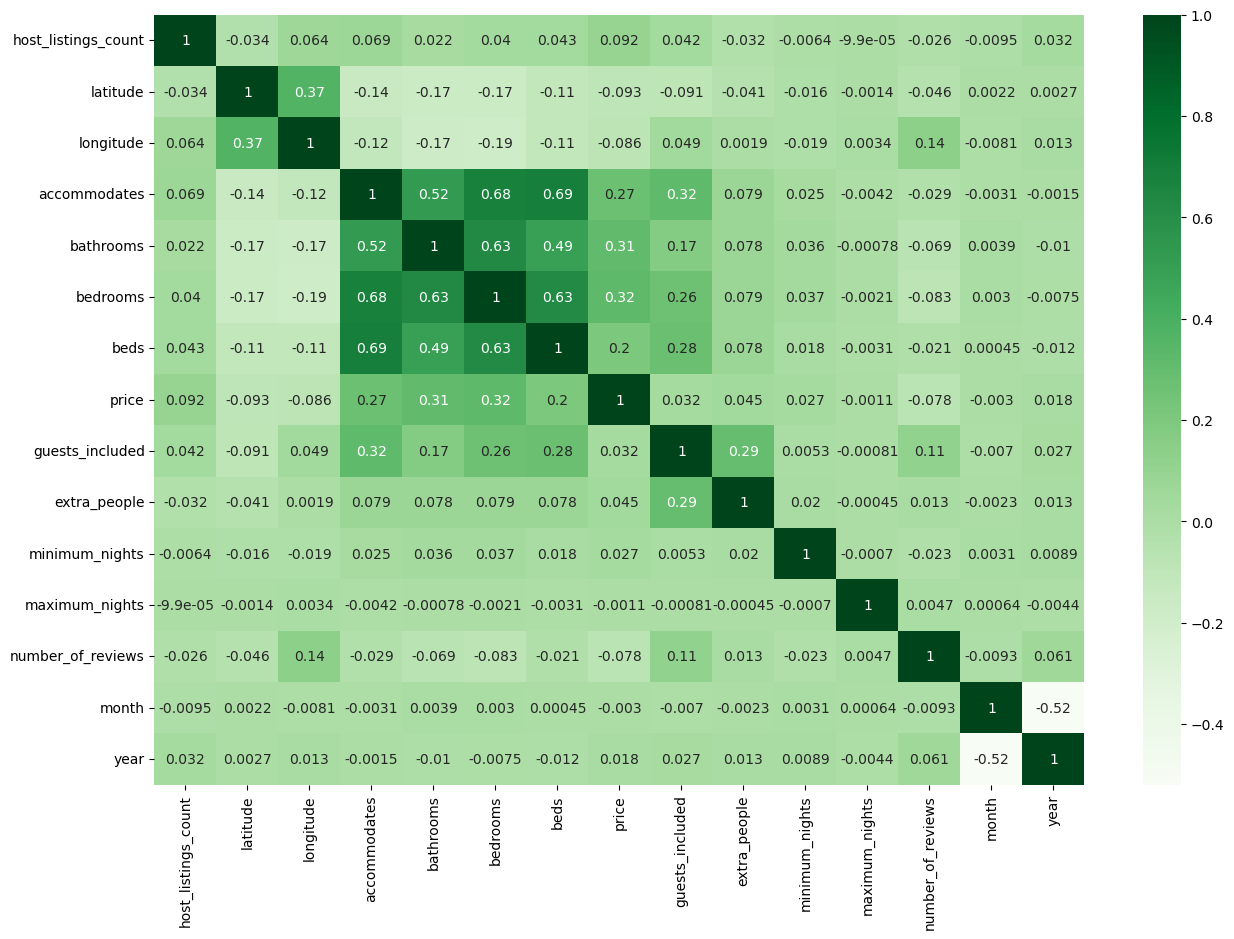

In [8]:
plt.figure(figsize=(15, 10))
print(db.corr(numeric_only=True))

sns.heatmap(db.corr(numeric_only=True), annot=True, cmap='Greens')

### Functions for the Outliers Analysis and Graphics
    - In the first view of the correlation between the columns, we can see there is a strong correlation between the number of beds, number of bathrooms and number of bedrooms and the number of people that the place acommodates, as expected;
    - Now we remove the outliers based on the quarters, as explained before. For that, we create functions to make the software easier to read, and implementing histograms, box diagrams and bar plots;
    - The box diagram will show two box plots: one with every value before removing the outliers on the left, and other with only the values inside the limits of the quarters on the right;
    - The histogram and bar plots are the distribution of the values after removing the outliers. The histogram will be used on continuous values and bar plots in discrete values.

In [9]:
def limits(column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    amplitude = q3 - q1

    lower_limit = q1 - 1.5*amplitude
    upper_limit = q3 + 1.5*amplitude 

    return lower_limit, upper_limit

def box_diagram(column):
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(12,4)

    sns.boxplot(x=column, ax=ax1)
    ax2.set_xlim(limits(column))
    sns.boxplot(x=column,ax=ax2)

def histogram(column):
    plt.figure(figsize=(12,4))
    sns.histplot(column, kde=True)

def barplot(column):
    plt.figure(figsize=(12,4))
    return sns.barplot(x = column.value_counts().index, y = column.value_counts())




def outliers_removal(db, column_name):
    n_lines = db.shape[0]
    lower_limit, upper_limit = limits(db[column_name])
    db = db.loc[(db[column_name] >= lower_limit) & (db[column_name] <= upper_limit),:]
    removed_lines = n_lines - db.shape[0] 

    return db, removed_lines

#### Analyzing the Price Column (Continuous value)
    - Right now, luxury apartments are not part of the scope of this study, being considered outliers in the database. So we proceed to remove what we consider outliers for this case, which are places with prices really above average;
    - After that, we can easily see on the histogram the 3 biggest peaks on 200, 150  and 250, in that order;
    - Also, most of the peaks of the whole graphic are in round values (100, 200, 300, etc) or +50 (150, 250, 350, etc). Thats expected of the human behaviour.

Database number of lines: 902210
87575 outliers removed from "price" column.
      New Database number of lines: 814635


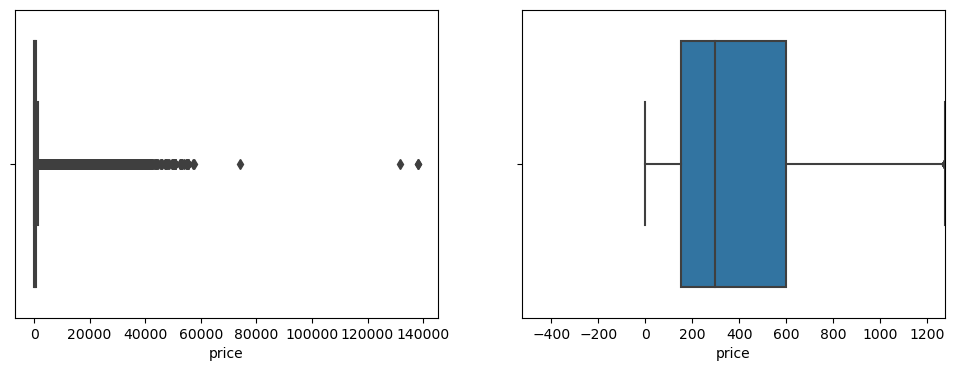

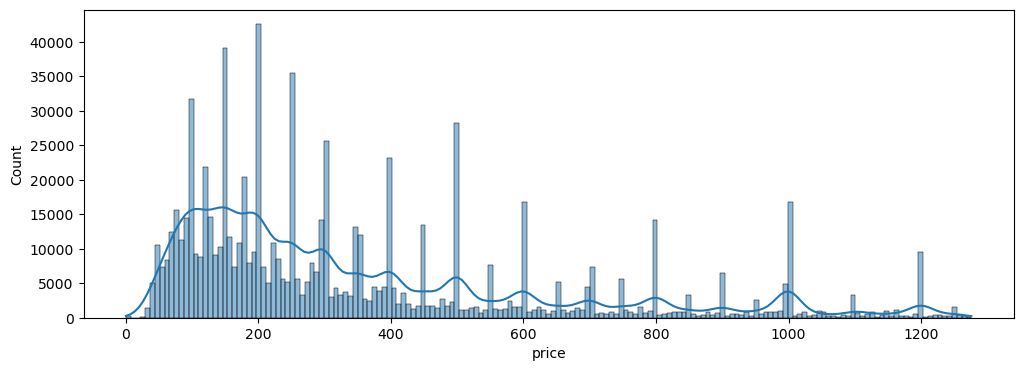

In [10]:
column_name = 'price'
box_diagram(db[column_name])
lines = db.shape[0]
print('Database number of lines: {}'.format(lines))

db, rem_lines = outliers_removal(db, column_name)

print('''{} outliers removed from "{}" column.
      New Database number of lines: {}'''.format(rem_lines, column_name,lines - rem_lines))

histogram(db[column_name])

#### Analyzing the extra_people Column (Continuous value)
    - That column is the value for each person that is added in the reservation, being similar to the price column
    - It seems that most of the users don't charge extra for aditional people in the reservation. This means if a couple look for a place that acommodates more than the two of them, it doesn't matter for the host, they have pay full price for it.

Database number of lines: 814635
59373 outliers removed from "extra_people" column.
      New Database number of lines: 755262


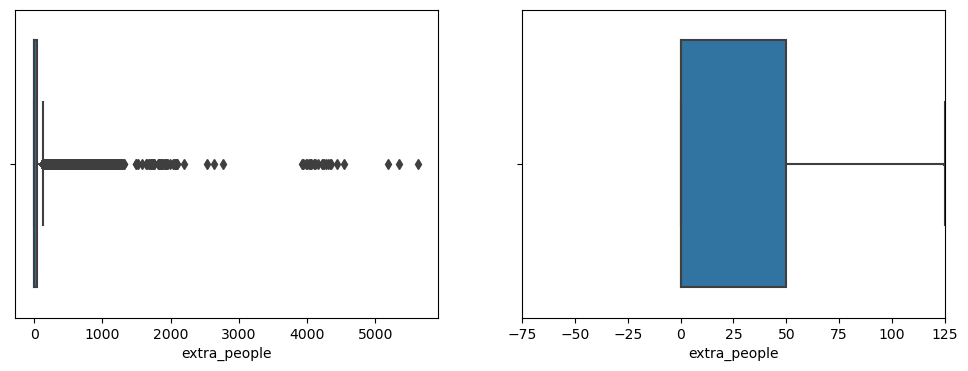

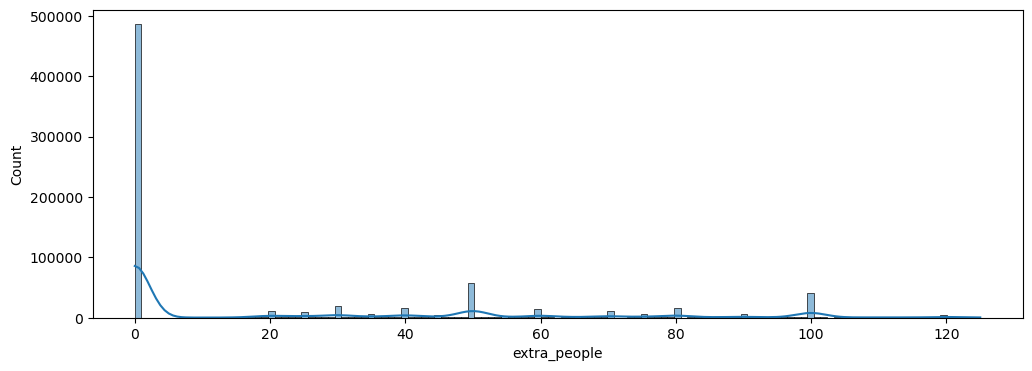

In [11]:
column_name = 'extra_people'
box_diagram(db[column_name])
lines = db.shape[0]
print('Database number of lines: {}'.format(lines))

db, rem_lines = outliers_removal(db, column_name)

print('''{} outliers removed from "{}" column.
      New Database number of lines: {}'''.format(rem_lines, column_name,lines - rem_lines))

histogram(db[column_name])

#### Analyzing the host_listings_counts Column (Discrete value)
    - That column is the number of places the same host have on Airbnb;
    - The outliers are people with a lot of places, most of them being companies that work renting places for others;
    - After removing those, we see that nearly half the database only have 1 place listed on the website.

Database number of lines: 755262
98749 outliers removed from "host_listings_count" column.
      New Database number of lines: 656513


<Axes: xlabel='host_listings_count', ylabel='count'>

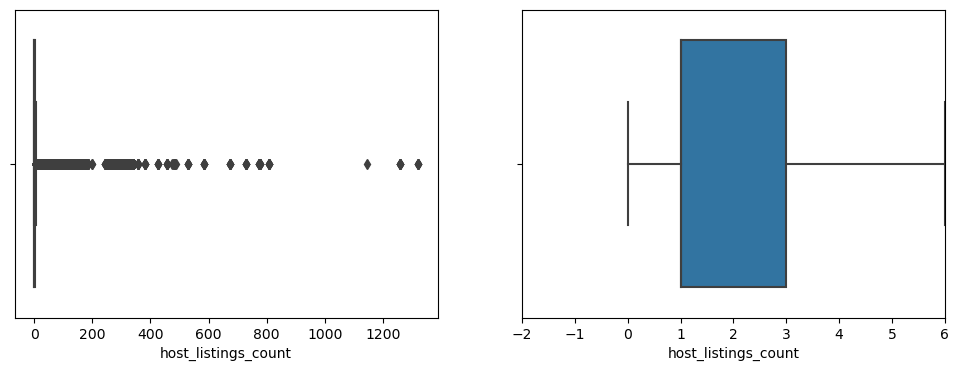

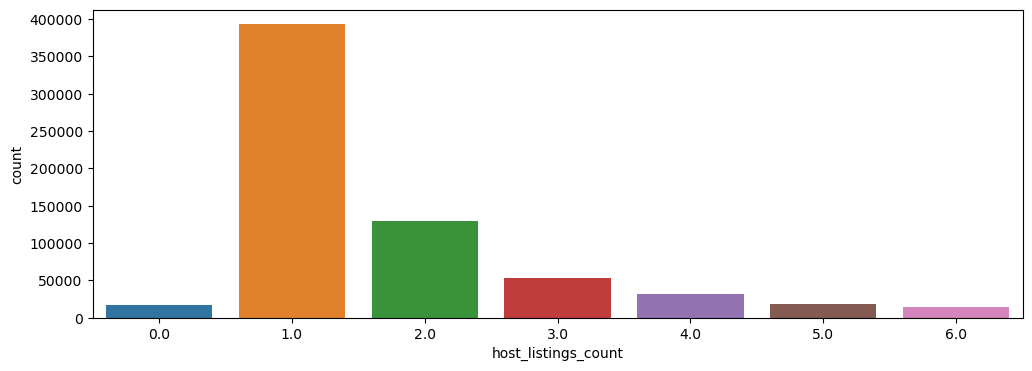

In [12]:
column_name = 'host_listings_count'
box_diagram(db[column_name])
lines = db.shape[0]
print('Database number of lines: {}'.format(lines))

db, rem_lines = outliers_removal(db, column_name)

print('''{} outliers removed from "{}" column.
      New Database number of lines: {}'''.format(rem_lines, column_name,lines - rem_lines))

barplot(db[column_name])

#### Analyzing the accommodates Column (Discrete value)
    - That column is the number of people each place accommodates;
    - Most of the data show that the places are for one or two couples.

Database number of lines: 656513
13183 outliers removed from "accommodates" column.
      New Database number of lines: 643330


<Axes: xlabel='accommodates', ylabel='count'>

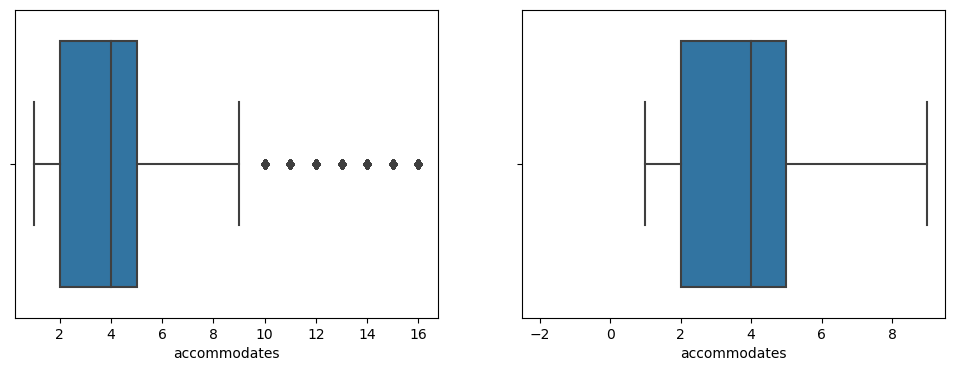

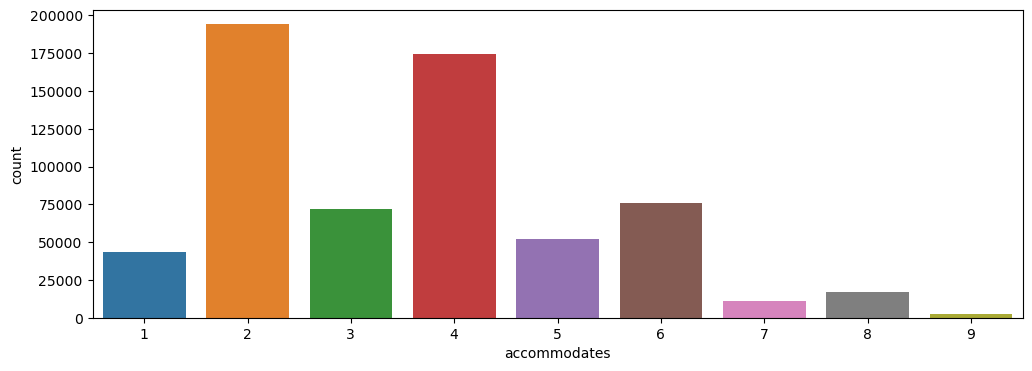

In [13]:
column_name = 'accommodates'
box_diagram(db[column_name])
lines = db.shape[0]
print('Database number of lines: {}'.format(lines))

db, rem_lines = outliers_removal(db, column_name)

print('''{} outliers removed from "{}" column.
      New Database number of lines: {}'''.format(rem_lines, column_name,lines - rem_lines))

barplot(db[column_name])

#### Analyzing the bathrooms Column (Discrete value)
    - That column is the number of bathrooms the place have;
    - The data shows that most places have just one bathroom;
    - Some places have .5 bathroom?? Maybe tha data its not reliable on this.

Database number of lines: 643330
8131 outliers removed from "bathrooms" column.
      New Database number of lines: 635199


<Axes: xlabel='bathrooms', ylabel='count'>

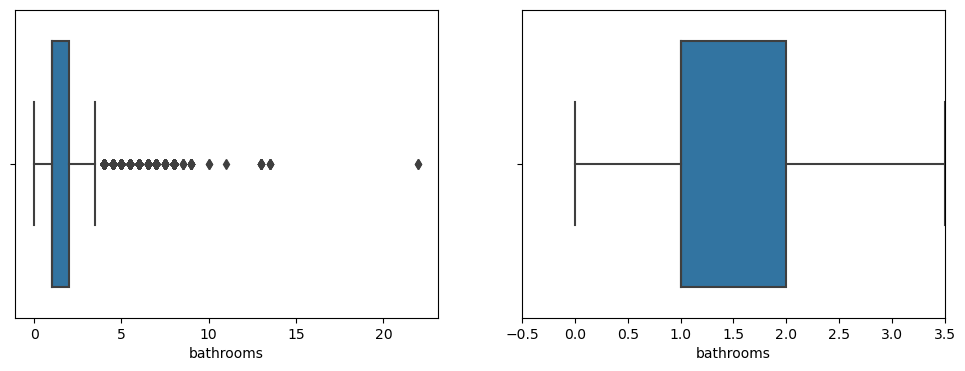

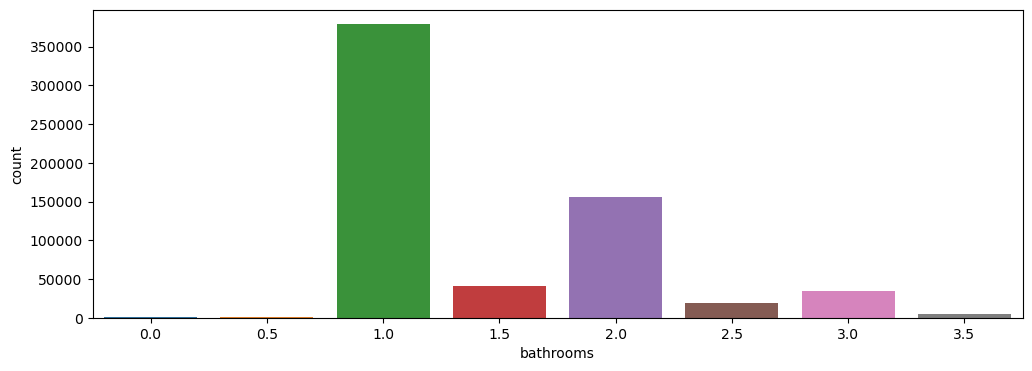

In [14]:
column_name = 'bathrooms'
box_diagram(db[column_name])
lines = db.shape[0]
print('Database number of lines: {}'.format(lines))

db, rem_lines = outliers_removal(db, column_name)

print('''{} outliers removed from "{}" column.
      New Database number of lines: {}'''.format(rem_lines, column_name,lines - rem_lines))

barplot(db[column_name])

#### Analyzing the bedrooms Column (Discrete value)
    - That column is the number of bedrooms the place have;
    - The data shows that most places have just one bedroom, as expected from what was shown in the bathrooms analyses;

Database number of lines: 635199
6043 outliers removed from "bedrooms" column.
      New Database number of lines: 629156


<Axes: xlabel='bedrooms', ylabel='count'>

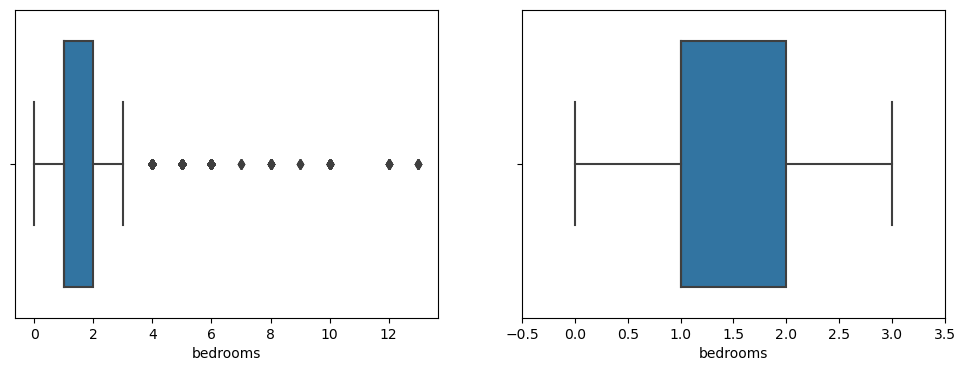

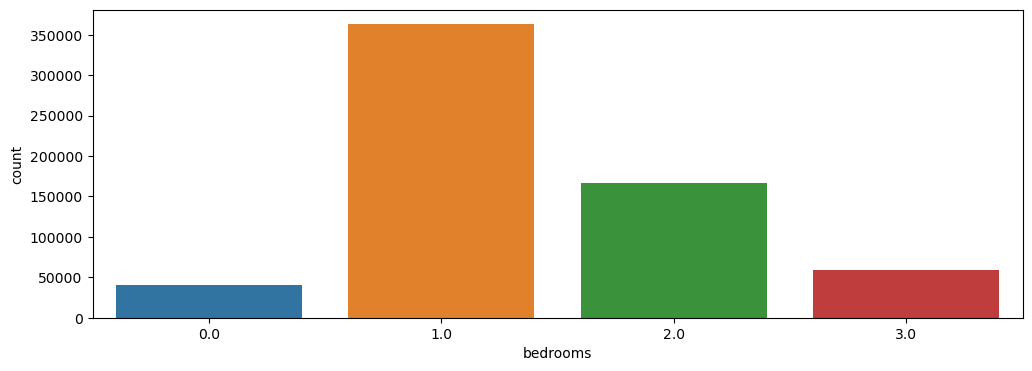

In [15]:
column_name = 'bedrooms'
box_diagram(db[column_name])
lines = db.shape[0]
print('Database number of lines: {}'.format(lines))

db, rem_lines = outliers_removal(db, column_name)

print('''{} outliers removed from "{}" column.
      New Database number of lines: {}'''.format(rem_lines, column_name,lines - rem_lines))

barplot(db[column_name])

#### Analyzing the beds Column (Discrete value)
    - That column is the number of beds the place have;
    - The data shows that number of beds is not directly alligned with the number of bedrooms. That's probably because they have a sofa or something similar that turns into a bed in the living room, for example;

Database number of lines: 629156
6790 outliers removed from "beds" column.
      New Database number of lines: 622366


<Axes: xlabel='beds', ylabel='count'>

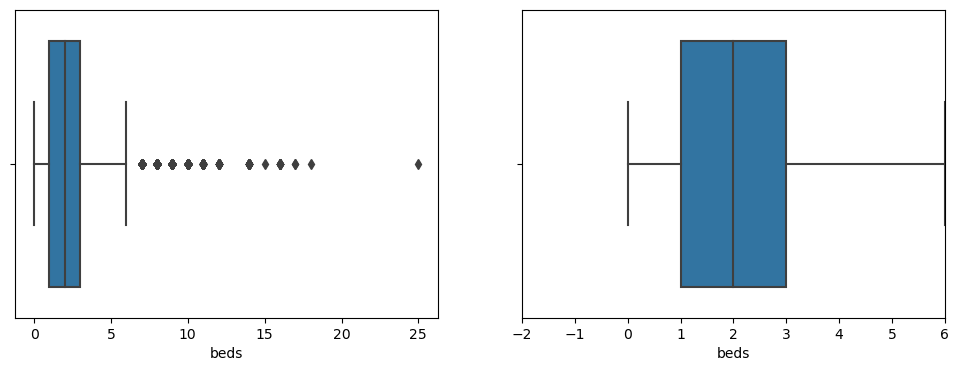

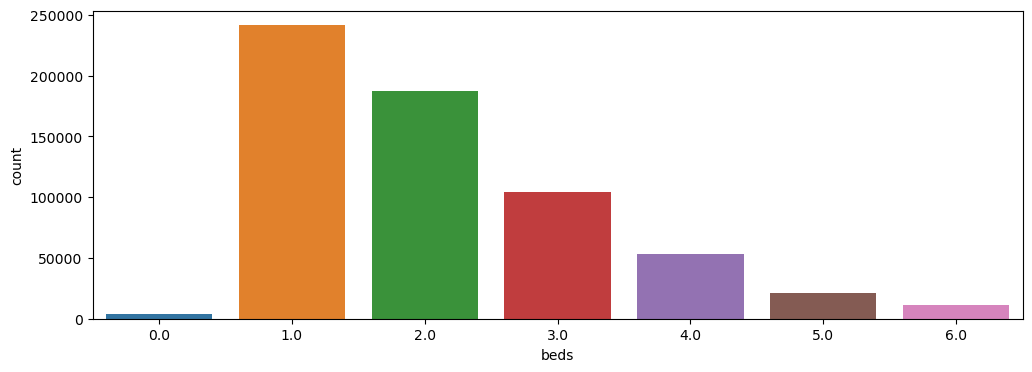

In [16]:
column_name = 'beds'
box_diagram(db[column_name])
lines = db.shape[0]
print('Database number of lines: {}'.format(lines))

db, rem_lines = outliers_removal(db, column_name)

print('''{} outliers removed from "{}" column.
      New Database number of lines: {}'''.format(rem_lines, column_name,lines - rem_lines))

barplot(db[column_name])

#### Analyzing the guests_included Column (Discrete value)
    - That column is the number of included in the reservation;
    - When analizing it, the conclusion is that the majority of the data is filled with 1, and that doesn't make any sense. This shows that the data is not reliable in this column. We proceed to remove it from the database.

C:\Users\ranon\AppData\Local\Temp\ipykernel_15212\561694761.py:16: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax2.set_xlim(limits(column))


(1.0, 1.0)


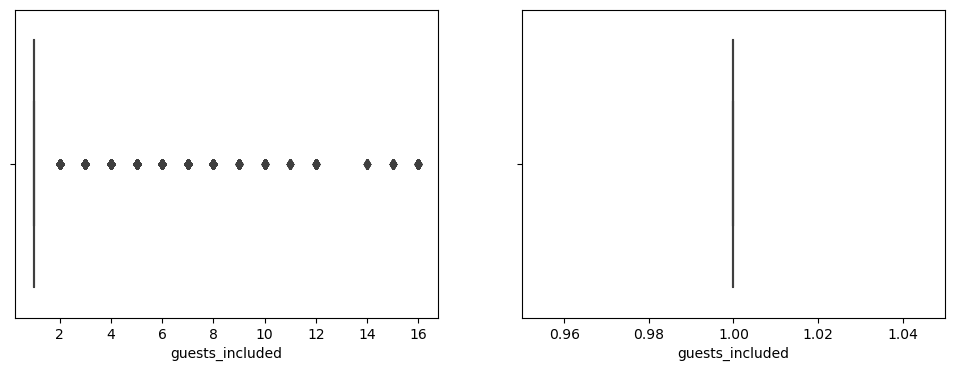

In [17]:
column_name = 'guests_included'
box_diagram(db[column_name])
print(limits(db[column_name]))
db = db.drop(column_name, axis=1)

#### Analyzing the minimum_nights Column (Discrete value)
    - That column is the minimum number of nights someone has to book the place;
    - The data shows that most ask for 1 to 3 nights minimum;

Database number of lines: 622366
40383 outliers removed from "minimum_nights" column.
      New Database number of lines: 581983


<Axes: xlabel='minimum_nights', ylabel='count'>

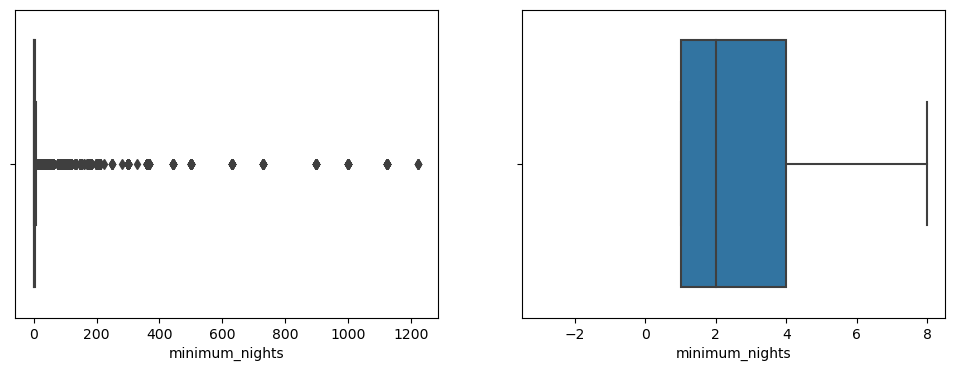

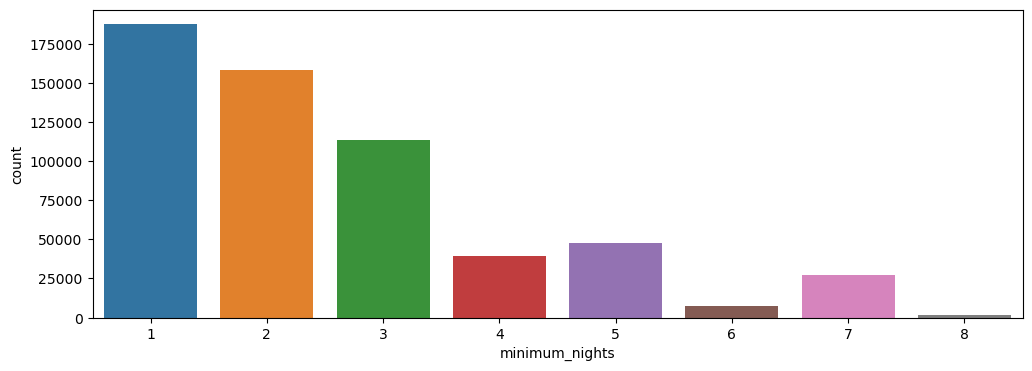

In [18]:
column_name = 'minimum_nights'
box_diagram(db[column_name])
lines = db.shape[0]
print('Database number of lines: {}'.format(lines))

db, rem_lines = outliers_removal(db, column_name)

print('''{} outliers removed from "{}" column.
      New Database number of lines: {}'''.format(rem_lines, column_name,lines - rem_lines))

barplot(db[column_name])

#### Analyzing the maximum_nights Column (Discrete value)
    - That column is the maximum number of nights that someone can book;
    - When analizing it, the conclusion is that the majority of the data doesn't make any sense, not being reliable. So it is removed it from the database.

(-1612.5, 2767.5)


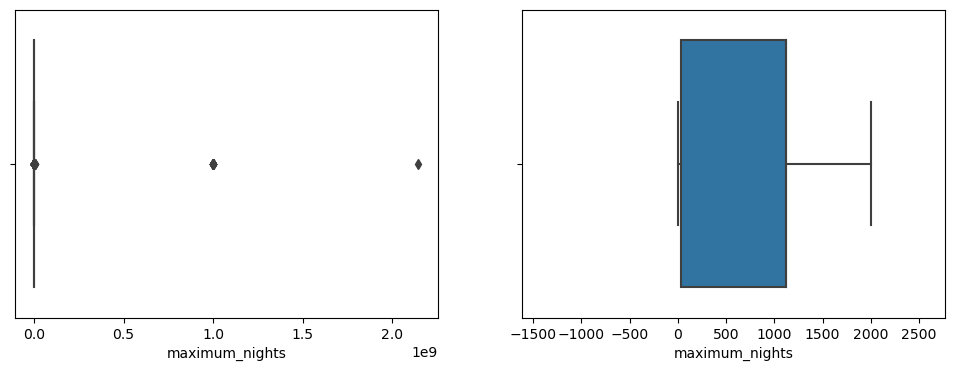

In [19]:
column_name = 'maximum_nights'
box_diagram(db[column_name])
print(limits(db[column_name]))
db = db.drop(column_name, axis=1)

#### Analyzing the number_of_reviews Column (Discrete value)
    - That column is the number of reviews the place have;
    - That's a value that depends on how many people booked it or even for how long it is on Airbnb. We shouldn't consider it in the model since we will be putting a new place to be evaluated. So we remove the column. 

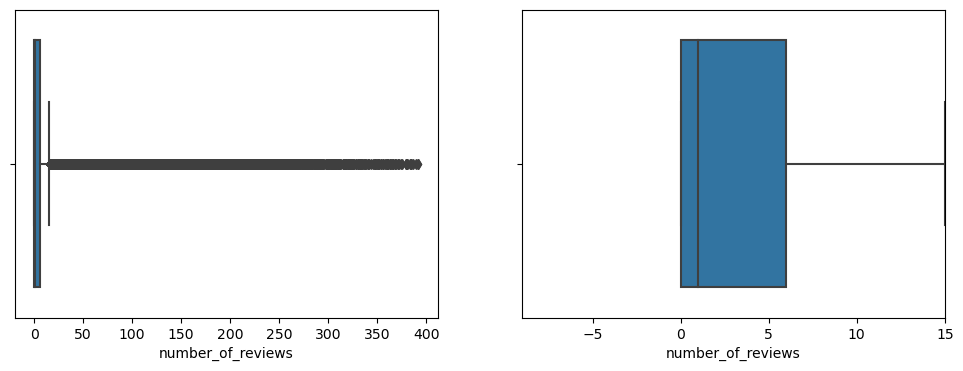

In [20]:
column_name = 'number_of_reviews'
box_diagram(db[column_name])
db = db.drop(column_name, axis=1)

#### Analyzing the property_type Column (Text Category value)
    - That column is the kind of property (Apartment, house, etc);
    - After seeing the distribution of it, we realized that places with less than 2000 values should be classified as Others;
    - Apartment is the majority of property type. 

property_type
Apartment                 458354
House                      51387
Condominium                26456
Serviced apartment         12671
Loft                       12352
Guest suite                 3621
Bed and breakfast           3472
Hostel                      2665
Guesthouse                  2155
Other                       1957
Villa                       1294
Townhouse                    969
Aparthotel                   693
Chalet                       481
Earth house                  468
Tiny house                   457
Boutique hotel               447
Hotel                        376
Casa particular (Cuba)       298
Cottage                      230
Bungalow                     207
Dorm                         185
Cabin                        141
Nature lodge                 124
Castle                        80
Treehouse                     76
Island                        54
Boat                          53
Hut                           40
Campsite                     

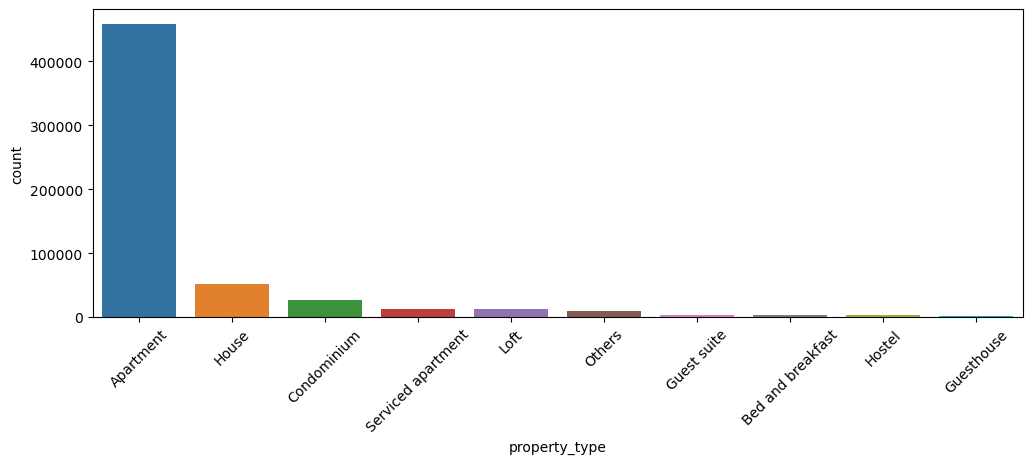

In [21]:
column_name = 'property_type'
print(db[column_name].value_counts())

prop_type_table = db[column_name].value_counts() 

for index in prop_type_table.index:
    if prop_type_table[index] <= 2000:
        db.loc[db[column_name] == index,column_name] = 'Others'

graph = barplot(db[column_name])
graph.tick_params(axis='x', rotation=45)

#### Analyzing the room_type Column (Text Category value)
    - That column is the kind of room in the property;
    - After seeing the distribution of it, there is no need to treat this column;
    - Entire home/apt is the majority of room type, followed by private room. 

room_type
Entire home/apt    372443
Private room       196859
Shared room         11714
Hotel room            967
Name: count, dtype: int64


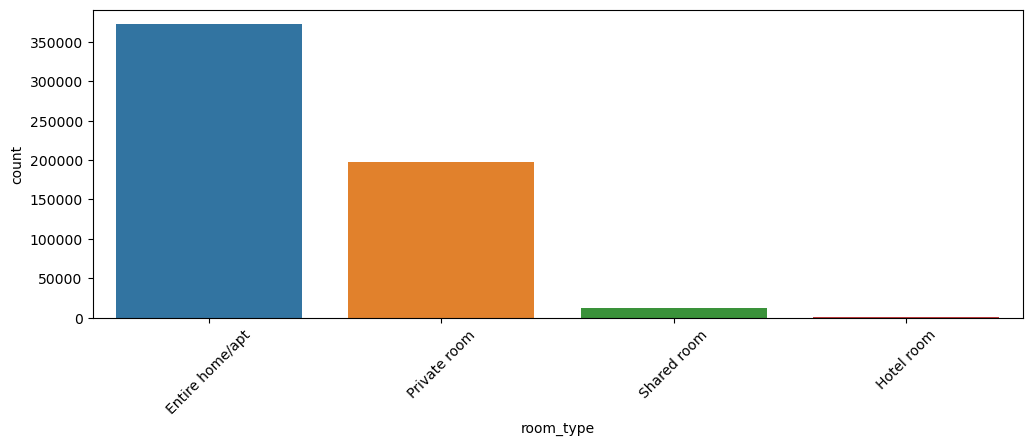

In [22]:
column_name = 'room_type'

print(db[column_name].value_counts())

graph = barplot(db[column_name])
graph.tick_params(axis='x', rotation=45)

#### Analyzing the bed_type Column (Text Category value)
    - That column is the kind of bed in the property;
    - After seeing the distribution of it, we decided to group up everything that is not 'Real Bed';
    - We ended up with only two classifications, which simplify the prediction model.

bed_type
Real Bed         570643
Pull-out Sofa      8055
Futon              1634
Airbed             1155
Couch               496
Name: count, dtype: int64


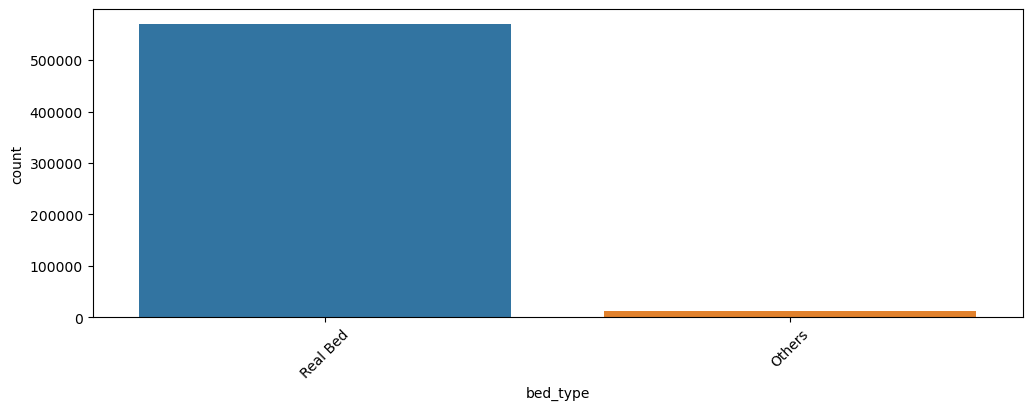

In [23]:
column_name = 'bed_type'

print(db[column_name].value_counts())

bed_table = db[column_name].value_counts() 

for index in bed_table.index:
    if index != 'Real Bed':
        db.loc[db[column_name] == index,column_name] = 'Others'

graph = barplot(db[column_name])
graph.tick_params(axis='x', rotation=45)

#### Analyzing the cancelation_policy Column (Text Category value)
    - That column is the kind of policy for cancelation the host works with;
    - After seeing the distribution of it, we will group up values with less than 10000 appearances;
    - flexible and strict_14_with_grace_period are almost equal, with flexible a little bit ahead. They are followed by moderate in third.

cancellation_policy
flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9696
super_strict_60                   135
super_strict_30                    32
Name: count, dtype: int64


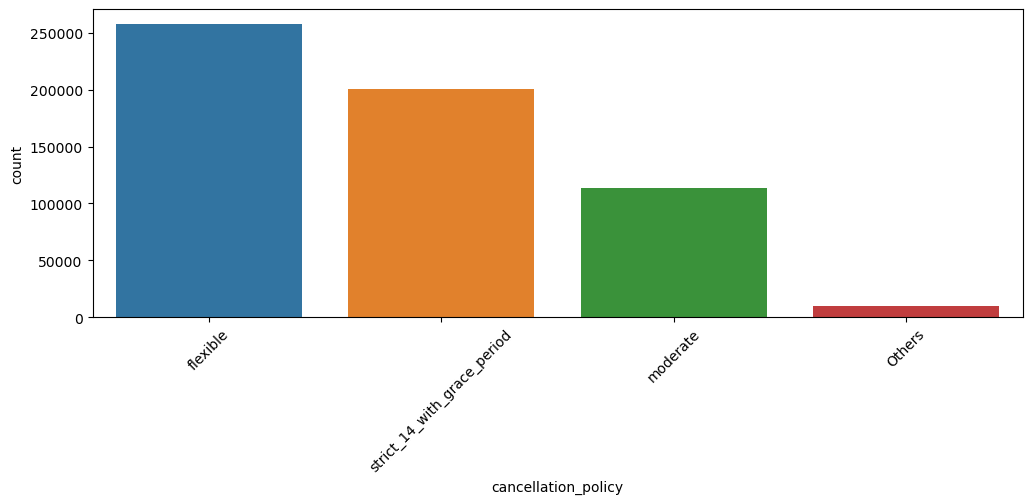

In [24]:
column_name = 'cancellation_policy'
print(db[column_name].value_counts())

cancelation_table = db[column_name].value_counts() 

for index in cancelation_table.index:
    if cancelation_table[index] <= 10000:
        db.loc[db[column_name] == index,column_name] = 'Others'

graph = barplot(db[column_name])
graph.tick_params(axis='x', rotation=45)

#### Analyzing the amenities Column (Text Category value/ Discrete value)
    - That column is the aditional services the room have (WiFi, TV, etc);
    - That's a list of strings, so it needs to be analysed in a different way;
    - We used the list's size to work with it, changing it into numbe of ammenities (n_amenities);
    - From that, it becomes a Discrete Value Column;
    - We proceed to work with it as we did in other Discrete Value Column, removing the outliers;
    - 12 is the amount of amenities that most places have.

Database number of lines: 581983
24343 outliers removed from "n_amenities" column.
      New Database number of lines: 557640


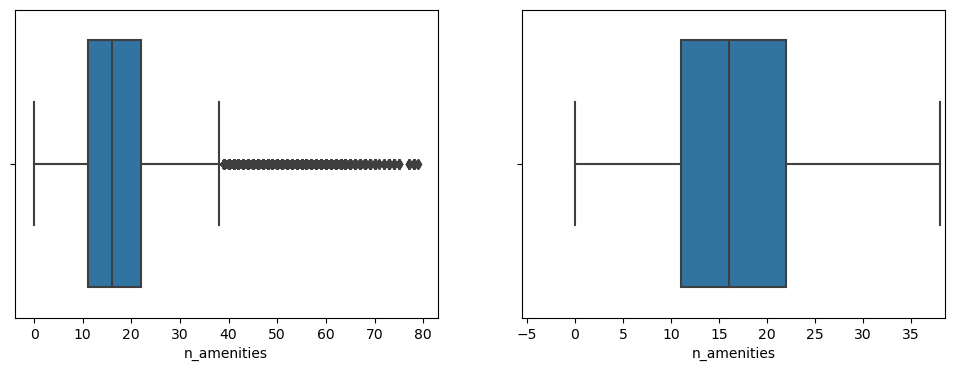

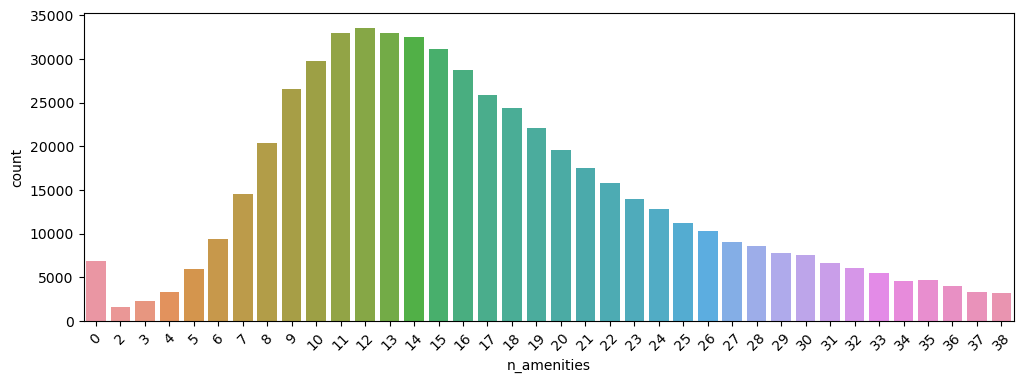

In [25]:
column_name = 'amenities'

amount_amenities = []
for amenities in db[column_name]:
    if ',' in amenities:
        amount_amenities.append(len(amenities.split(',')))
    else:
        amount_amenities.append(0)

db = db.drop(column_name, axis=1)

new_column_name = 'n_amenities'
db[new_column_name] = amount_amenities

amenities_table = db[new_column_name].value_counts() 

box_diagram(db[new_column_name])
lines = db.shape[0]
print('Database number of lines: {}'.format(lines))

db, rem_lines = outliers_removal(db, new_column_name)

print('''{} outliers removed from "{}" column.
      New Database number of lines: {}'''.format(rem_lines, new_column_name,lines - rem_lines))

graph = barplot(db[new_column_name])
graph.tick_params(axis='x', rotation=45)

#### Analyzing the distribution of price within the location (latitude and longitude) Columns in a map (Location value)
    - Now we analyze a combination of columns that, together, define the location of the place in question;
    - The columns 'latitude' and 'longitude' give the geolocation of each apartment/house in the database;
    - First we select a random sample of the database (50000 lines), in order to be better to visualize the difference in values in the ploted map;
    - Second we select the center of the map accordingly with the mean of the latitude and the longitude in the sample;
    - In the end, we plot the map, with the color following the pattern of the price;
    - Ipanema, Leblon, Copacabana (south of Rio) and places close to the airport are the ones with more expensive places;
    - Surprisigling, Parque Olímpico also have expensive places. That can be explained because it's a location where most events occur in Rio de Janeiro.

In [26]:
sample = db.sample(n=50000)

map_center = {'lat': sample['latitude'].mean(), 'lon': sample['longitude'].mean()}
fig = px.density_mapbox(sample, lat='latitude', lon='longitude', z='price', radius=2.5, center=map_center, zoom=10, mapbox_style='open-street-map')

fig.show()

### Encoding in columns with True/False values and Text Category values
    - The model can't read text, so we have to adapt the database, changing the text to something readable to the model;
    - First, we treat the columns with True/False value. For example 'is_host_superhost', a column with the information is a superhost (True) or not (False);
    - So what is True will be 1, and False will be 0;
    - In columns with categories, will choose to use One-Hot Enconding. An example of column is 'cancelation_policy';
    - In that method, we create new columns for each categorie and fill it with 1 the places that are in that category and 0 in the others column;
    - For better visualization, we separate the enconding in two cells: one for the True/False values and other for the One-Hot Enconding.



In [27]:
db_encoded = db.copy()
true_false_columns = ['host_is_superhost', 'instant_bookable', 'is_business_travel_ready']

for column in true_false_columns:
    db_encoded.loc[db_encoded[column] == 't',column] = 1
    db_encoded.loc[db_encoded[column] == 'f',column] = 0


In [28]:
category_columns = ['property_type', 'room_type', 'bed_type', 'cancellation_policy']

db_encoded = pd.get_dummies(data=db_encoded, columns=category_columns) 


### Prediction Model
    - Now we proceed to choose the most suitable model in 7 steps:
    1- Analyzing if it is a classification of regression model. In this case, is regression. We want to find the price of a place to book in Airbnb;
    2- Defining the metrics of the model evaluation. We will use R**2 and RSME. The first tell us "how much the model gets right" and the second "how much the model gets wrong".
    3- Choosing the model itself. In our case, we will test 3 models and choose between then.
    4- Training and testing the models;
    5- Comparing the models and choosing the best one. We will use the metrics defined in the third step.
    6- Analysing how the model works. This means we see how the variables (columns of the database) change the final value and the weight of each.
    7- Optimize and adjusting the best model. Based on what we learned on the sixth step, we adapt the model so it gets even better.

    In the first cell we do the steps 3 to 6, comparing the models. The models choosen for this were Linear Regression, Random Forest Regression and Extra Trees.

Model: Random Forest
R²: 97.38%
RSME: 42.90
Time to train, predict and evaluate: 0:03:49.068789



0
bedrooms                                         0.189053
latitude                                         0.161266
longitude                                        0.159115
extra_people                                     0.092933
n_amenities                                      0.087443
accommodates                                     0.054953
minimum_nights                                   0.052096
bathrooms                                        0.040261
beds                                             0.030976
host_listings_count                              0.026504
instant_bookable                                 0.014291
cancellation_policy_flexible                     0.012111
room_type_Entire home/apt                        0.011520
property_type_Apartment                          0.008214
cancellation_policy_moderate                     0.007697
room_type_Private room                           0.007252
cancellation_policy_strict_14_with_grace_period  0.006502
year                                             0.005879
host_is_superhost                                0.005826
property_type_House                              0.004290
month                                            0.004173
property_type_Condominium                        0.003974
property_type_Loft                               0.002086
bed_type_Others                                  0.001766
bed_type_Real Bed                                0.001669
property_type_Bed and breakfast                  0.001473
property_type_Others                             0.001456
property_type_Serviced apartment                 0.001433
room_type_Shared room                            0.001164
property_type_Guesthouse                         0.000795
cancellation_policy_Others                       0.000581
property_type_Hostel                             0.000577
property_type_Guest suite                        0.000426
room_type_Hotel room                             0.000247
is_business_travel_ready                         0.000000

Model: Linear Regression
R²: 32.72%
RSME: 217.32
Time to train, predict and evaluate: 0:00:00.494684

Model: Extra Tree
R²: 97.52%
RSME: 41.69
Time to train, predict and evaluate: 0:03:06.998732



0
bedrooms                                         0.127894
latitude                                         0.104425
longitude                                        0.100942
n_amenities                                      0.089373
extra_people                                     0.086614
accommodates                                     0.067006
room_type_Entire home/apt                        0.065857
minimum_nights                                   0.064510
bathrooms                                        0.062476
beds                                             0.052582
host_listings_count                              0.039389
instant_bookable                                 0.021834
cancellation_policy_flexible                     0.019638
host_is_superhost                                0.013168
cancellation_policy_moderate                     0.012636
property_type_Apartment                          0.012448
year                                             0.011218
cancellation_policy_strict_14_with_grace_period  0.007711
property_type_House                              0.007197
property_type_Condominium                        0.005230
month                                            0.004711
room_type_Private room                           0.004368
bed_type_Others                                  0.002723
bed_type_Real Bed                                0.002719
property_type_Others                             0.002300
property_type_Loft                               0.002193
property_type_Serviced apartment                 0.002180
room_type_Shared room                            0.001821
property_type_Bed and breakfast                  0.001399
property_type_Guesthouse                         0.000990
cancellation_policy_Others                       0.000894
property_type_Guest suite                        0.000656
property_type_Hostel                             0.000630
room_type_Hotel room                             0.000268
is_business_travel_ready                         0.000000

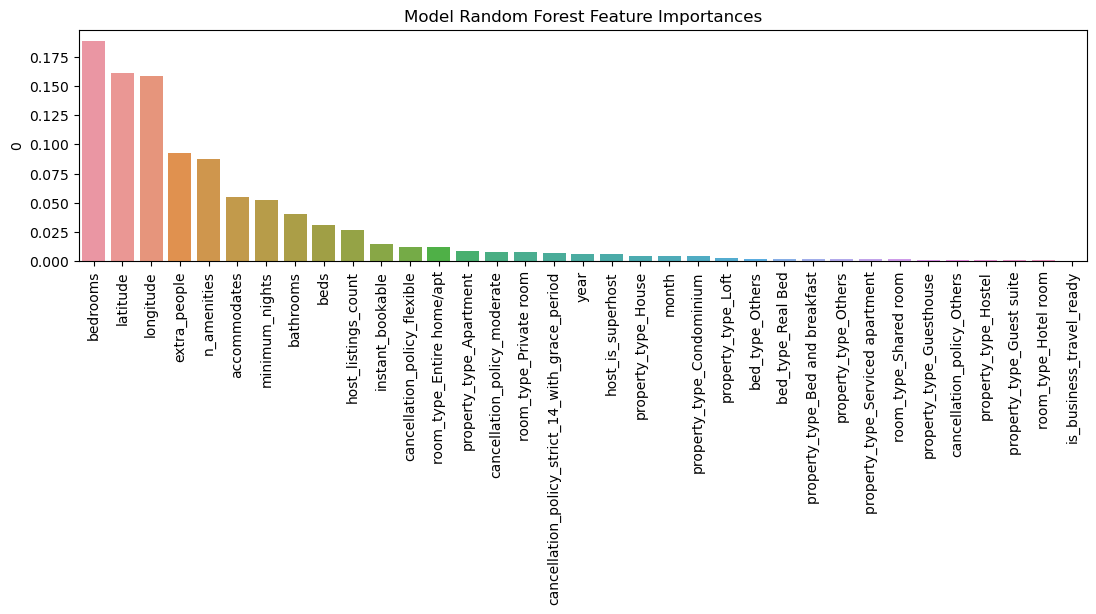

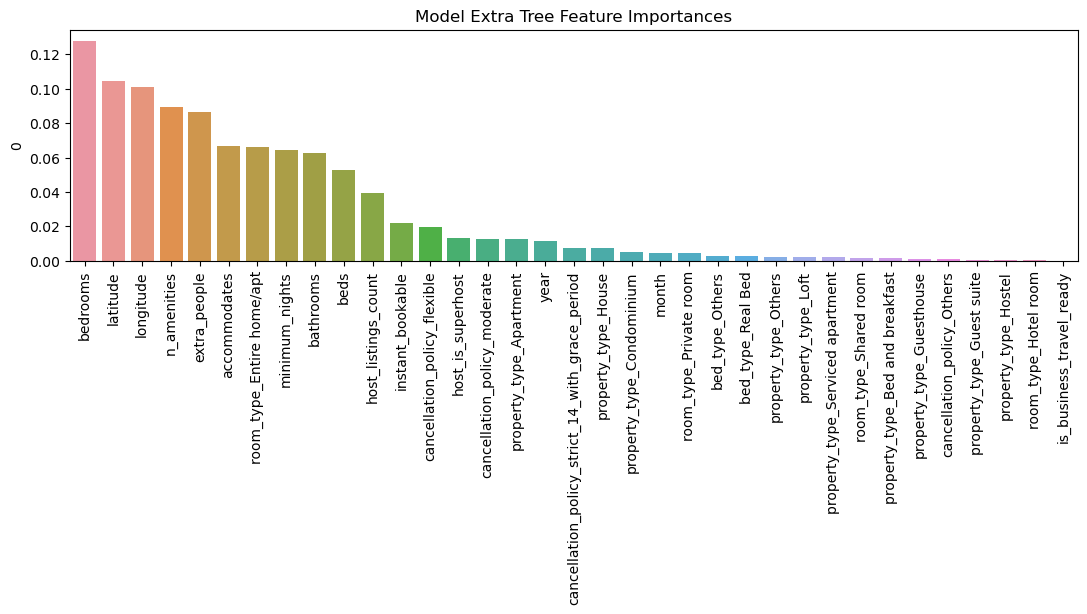

In [29]:
# 1 - Function to help evaluate each model
def evaluate_model(model_name, y_test, prediction, start):
    
    r2 = r2_score(y_test, prediction)
    RSME = np.sqrt(mean_squared_error(y_test, prediction))
    time_spent = datetime.now() - start

    return 'Model: {}\nR²: {:.2%}\nRSME: {:.2f}\nTime to train, predict and evaluate: {}\n'.format(model_name, r2, RSME, time_spent)

# 2 - Organizing the models for the loop
rf_model  = RandomForestRegressor()
lr_model = LinearRegression()
et_model  = ExtraTreesRegressor()

models = {'Random Forest': rf_model,
          'Linear Regression': lr_model,
          'Extra Tree': et_model}

# 3 - Separating teh database in target (y variable) and the data to predict it (x variable)
y = db_encoded['price']
x = db_encoded.drop('price', axis=1)

# 4 - Spliting the training and testing values
x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=42)
index_features = x_train.columns

# 5 - Loop to show the results and analyze how the features influence each model
for model_name, model in models.items():

    start = datetime.now()
    model.fit(x_train, y_train)
    prediction = model.predict(x_test)
    print(evaluate_model(model_name, y_test, prediction, start))

    if model_name != 'Linear Regression':

        feature_importances = pd.DataFrame(model.feature_importances_, index_features)
        feature_importances = feature_importances.sort_values(by=0, ascending=False)
        display(feature_importances)

        plt.figure(figsize=(13,3))
        ax = sns.barplot(x=feature_importances.index, y=feature_importances[0])
        ax.set_title('Model {} Feature Importances'.format(model_name))
        ax.tick_params(axis='x', rotation=90)


### Determining the most suitable model and making last adjustments
    - R**2 will be the main metric, followed by the RSME;
    - In cases were the model takes to long to train or do predictions, it will be discarded;
    - Models that needs less information will be preferred as well;
    - Following these criterias, we have choosen Extra Trees, which had the best results overall as shown below:
        Model: Extra Tree
        R²: 97.54%
        RSME: 41.57
        Time to train, predict and evaluate: 0:03:22.524283
    
    - When we look further in the features importances for the Extra Trees model, we decide to remove is_business_travel_ready and the features related to bed_type (bed_type_Real Bed and bed_type_Others);
    - The first doesn't seem to be used in the model and the second has little influence, so they will be removed in order to it be faster and evaluate the impact in the model evaluation;


Model: Extra Trees
R²: 97.51%
RSME: 41.79
Time to train, predict and evaluate: 0:02:57.662961



0
bedrooms                                         0.113893
latitude                                         0.105796
longitude                                        0.102503
n_amenities                                      0.090251
extra_people                                     0.086990
accommodates                                     0.078271
minimum_nights                                   0.065581
bathrooms                                        0.065403
room_type_Entire home/apt                        0.064584
beds                                             0.052570
host_listings_count                              0.039539
instant_bookable                                 0.022296
cancellation_policy_flexible                     0.019783
host_is_superhost                                0.013161
property_type_Apartment                          0.012622
cancellation_policy_moderate                     0.012445
year                                             0.011281
cancellation_policy_strict_14_with_grace_period  0.007576
property_type_House                              0.007182
property_type_Condominium                        0.005309
month                                            0.004719
room_type_Private room                           0.004543
property_type_Loft                               0.002396
property_type_Others                             0.002333
property_type_Serviced apartment                 0.002295
room_type_Shared room                            0.001878
property_type_Bed and breakfast                  0.001360
property_type_Guesthouse                         0.000983
cancellation_policy_Others                       0.000896
property_type_Guest suite                        0.000658
property_type_Hostel                             0.000622
room_type_Hotel room                             0.000281

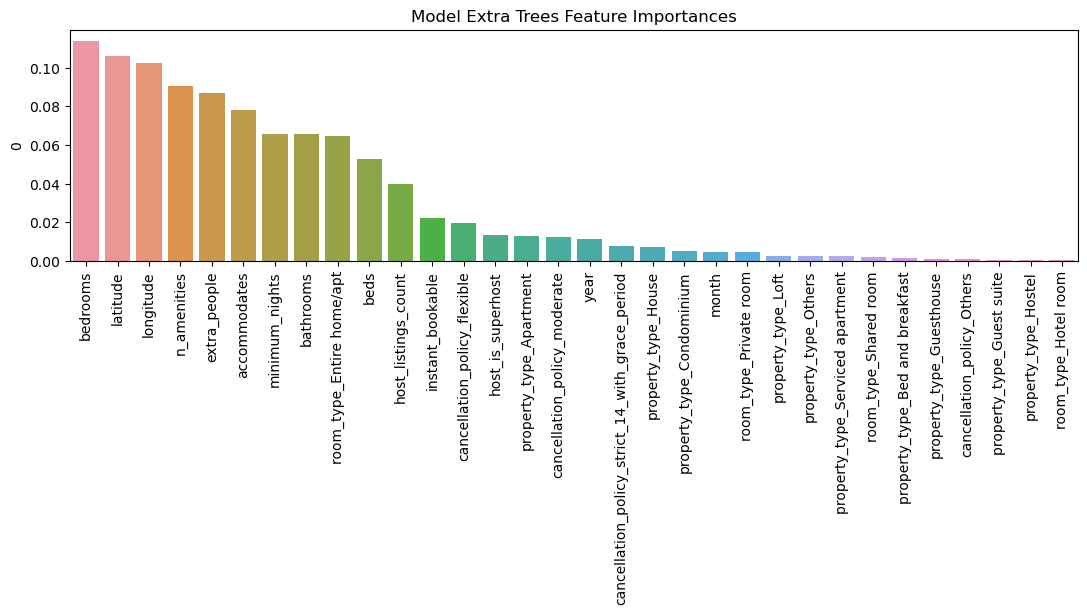

In [30]:
db_filtered = db_encoded.copy()

removed_features = ['is_business_travel_ready',
                    'bed_type_Real Bed',
                    'bed_type_Others']

for feature in removed_features:
    db_filtered = db_filtered.drop(feature, axis=1)

y = db_filtered['price']
x = db_filtered.drop('price', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=42)
index_features = x_train.columns

start = datetime.now()
et_model.fit(x_train, y_train)
prediction = et_model.predict(x_test)
print(evaluate_model('Extra Trees', y_test, prediction, start))

feature_importances = pd.DataFrame(et_model.feature_importances_, index_features)
feature_importances = feature_importances.sort_values(by=0, ascending=False)
display(feature_importances)

plt.figure(figsize=(13,3))
ax = sns.barplot(x=feature_importances.index, y=feature_importances[0])
ax.set_title('Model {} Feature Importances'.format('Extra Trees'))
ax.tick_params(axis='x', rotation=90)

### Final Toughts
    - As we can see, after removing the selected features, we got a faster model with virtually the same quality of prediction;
    - In conclusion, the model will be better removing the selected columns and does a good jog predicting the price of a place in Rio de Janeiro.
    - Final numbers:
        Model: Extra Trees
        R²: 97.52%
        RSME: 41.71
        Time to train, predict and evaluate: 0:02:45.738141

    - Now we proceed to save the DataBase treated in a csv file and create a joblib file of the model for future use of it.

In [31]:
db_filtered['price'] = y
db_filtered.to_csv('DataBase_Treated.csv')

In [32]:
import joblib
joblib.dump(et_model, 'ExtraTrees_Model.joblib')